In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import ConfusionMatrixDisplay, classification_report

import re
import string

import os
from IPython.display import clear_output
from tqdm import tqdm

In [43]:
train_df = pd.read_json('data/snli_1.0_train.jsonl', lines=True)
test_df = pd.read_json('data/snli_1.0_test.jsonl', lines=True)
dev_df = pd.read_json('data/snli_1.0_dev.jsonl', lines=True)

train_df = train_df.drop(train_df[train_df['gold_label']=='-'].index)
train_df = train_df.sample(frac=0.02, random_state=42).reset_index(drop=True)

test_df = test_df.drop(test_df[test_df['gold_label']=='-'].index)
test_df = test_df.sample(frac=0.2, random_state=42).reset_index(drop=True)

In [44]:
def clean_text(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [45]:
train_df.loc[:, 'sentence1'] = train_df.loc[:, 'sentence1'].apply(lambda s: clean_text(s))
train_df.loc[:, 'sentence2'] = train_df.loc[:, 'sentence2'].apply(lambda s: clean_text(s))

test_df.loc[:, 'sentence1'] = test_df.loc[:, 'sentence1'].apply(lambda s: clean_text(s))
test_df.loc[:, 'sentence2'] = test_df.loc[:, 'sentence2'].apply(lambda s: clean_text(s))

In [46]:
# Entailment vs Not Entailment as CosineLoss only takes -1 and 1 as true labels
def le(gold):
    if gold=='neutral': return -1
    elif gold=='entailment': return 1
    else: return -1
    
train_df['y'] = train_df['gold_label'].apply(le)
test_df['y'] = test_df['gold_label'].apply(le)

In [47]:
train_df.loc[22, ['sentence1', 'sentence2', 'gold_label', 'y']]

sentence1     it looks to be a glass maker heating up some g...
sentence2                                   glass is heating up
gold_label                                           entailment
y                                                             1
Name: 22, dtype: object

In [48]:
vocab = {'<unk>':0}
sentences = pd.concat((train_df['sentence1'], train_df['sentence2']), axis=0).reset_index(drop=True)

for i, sentence in enumerate(sentences):
    sent_split = sentence.split()
    for word in sent_split:
        word = word.lower()
        if word not in vocab:
            vocab[word] = len(vocab)

print(len(vocab))

8625


In [49]:
def prepare_sequence(sentence, vocab):
    idxs = [vocab[word] if word in vocab else 0 for word in sentence]
    return torch.tensor(idxs, dtype=torch.long)

In [50]:
class LSTM_entailer(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()

        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        pretrained_fasttext_embeddings  = torch.rand((vocab_size,embedding_dim))
        self.word_embeddings.weight.data.copy_(pretrained_fasttext_embeddings)

        self.lstm = nn.LSTM(embedding_dim, hidden_dim)


    def forward(self, sentence1, sentence2):
        embeds1 = self.word_embeddings(sentence1)
        embeds2 = self.word_embeddings(sentence2)

        out1, _ = self.lstm(embeds1.view(len(sentence1), 1, -1))
        out2, _ = self.lstm(embeds2.view(len(sentence2), 1, -1))

        out1 = out1[-1]
        out2 = out2[-1]

        return out1, out2

# Model Training and Stuff

In [51]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [124]:
model_folder = f"models/Test_model"
os.makedirs(model_folder, exist_ok=True)
os.makedirs('figs', exist_ok=True)

In [53]:
vocab_size, embedding_dim, hidden_dim = len(vocab), 6, 4
model = LSTM_entailer(vocab_size, embedding_dim, hidden_dim).to(device)

lossFn = torch.nn.CosineEmbeddingLoss(margin=0).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

history = {
    "train_loss": [],
    "train_accuracy": [],
    "test_accuracy": []
}

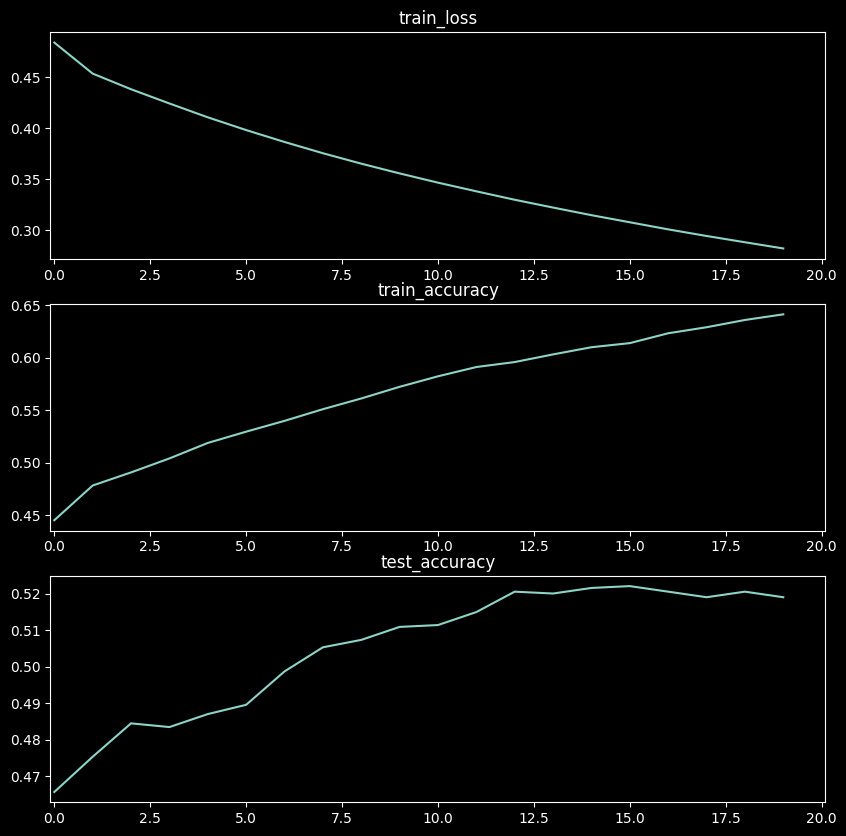

In [54]:
epochs=20
for epoch in range(epochs):

    train_loss = 0
    train_accuracy = 0
    test_accuracy = 0

    model.train()
    for i, (sentence1, sentence2, y) in tqdm(train_df[['sentence1', 'sentence2', 'y']].iterrows(), total=len(train_df)):
        sentence1 = prepare_sequence(sentence1.split(), vocab).to(device)
        sentence2 = prepare_sequence(sentence2.split(), vocab).to(device)
        y = torch.as_tensor(y).view(-1).to(device)
        out1, out2 = model(sentence1, sentence2)

        pred = F.cosine_similarity(out1, out2)
        loss = lossFn(out1, out2, y)

        train_loss += loss.item()
        train_accuracy += (y == 2*(pred>=0)-1).item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(train_df)
    train_accuracy /= len(train_df)

    ## Testing stuff ##

    model.eval()
    for i, (sentence1, sentence2, y) in tqdm(test_df[['sentence1', 'sentence2', 'y']].iterrows(), total=len(test_df)):
        sentence1 = prepare_sequence(sentence1.split(), vocab).to(device)
        sentence2 = prepare_sequence(sentence2.split(), vocab).to(device)
        y = torch.as_tensor(y).view(-1).to(device)
        out1, out2 = model(sentence1, sentence2)

        pred = F.cosine_similarity(out1, out2)
        test_accuracy += (y == 2*(pred>=0)-1).item()

    test_accuracy /= len(test_df)

    ###################

    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }

    if len(history['test_accuracy']) and test_accuracy >= max(history['test_accuracy']):
        torch.save(state, f"{model_folder}/best.pth")

    history['train_loss'].append(train_loss)
    history['train_accuracy'].append(train_accuracy)
    history['test_accuracy'].append(test_accuracy)
    
    #########################################
    clear_output(wait=True)
    fig, axs = plt.subplots(len(history),1,figsize=(10,10))

    for i, key in enumerate(history.keys()):
        ax = axs[i]
        ax.set_xlim(-0.1, epochs+0.1)
        ax.set_title(key)

        ax.plot(history[key])
    plt.show()
    #########################################

    torch.save(history, f"{model_folder}/history.pth")
    torch.save(state, f"{model_folder}/latest.pth")
    
    ##########################################

# Model Loading and Testing

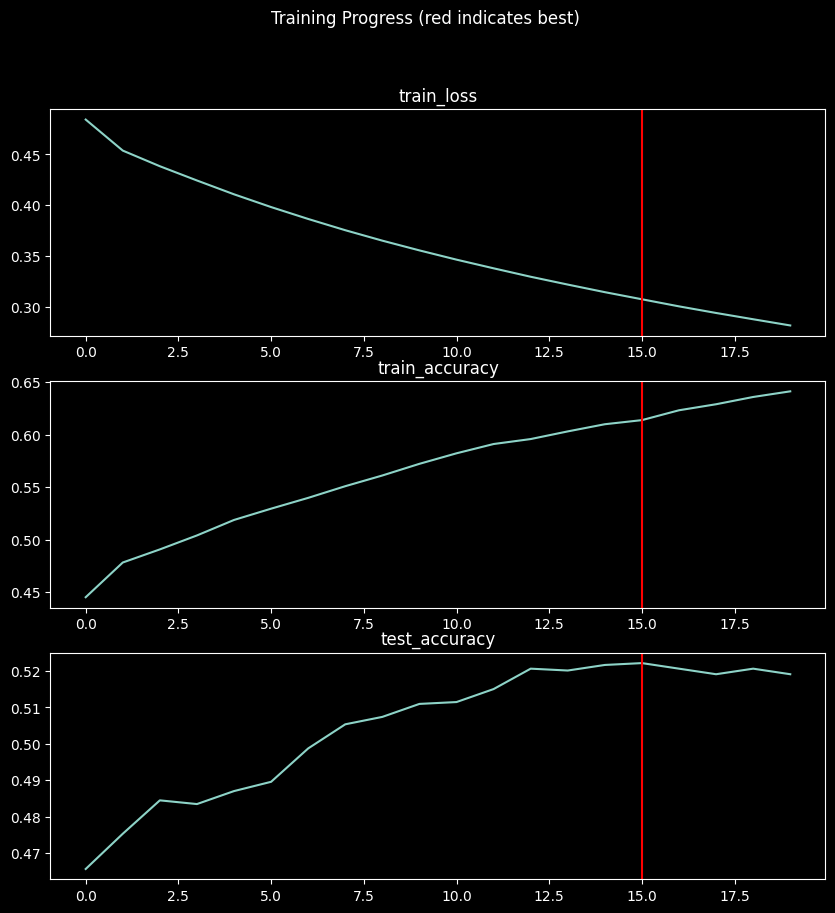

In [121]:
state = torch.load(f"{model_folder}/best.pth")
history = torch.load(f"{model_folder}/history.pth")

vocab_size, embedding_dim, hidden_dim = len(vocab), 6, 4
model = LSTM_entailer(vocab_size, embedding_dim, hidden_dim).to(device)
model.load_state_dict(state['state_dict'])

fig, axs = plt.subplots(len(history),1,figsize=(10,10))
test_best = state['epoch']

for i, key in enumerate(history.keys()):
    ax = axs[i]
    ax.set_title(key)

    ax.plot(history[key])
    ax.axvline(test_best, color='red')

plt.suptitle("Training Progress (red indicates best)")
plt.savefig('figs/Training Progress.jpg')

In [118]:
max(history['test_accuracy'])

0.5221374045801527

  0%|                                                                                         | 0/10987 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████| 10987/10987 [00:18<00:00, 608.75it/s]


              precision    recall  f1-score   support

          -1       0.88      0.49      0.63      7399
           1       0.45      0.86      0.59      3588

    accuracy                           0.61     10987
   macro avg       0.66      0.67      0.61     10987
weighted avg       0.74      0.61      0.61     10987



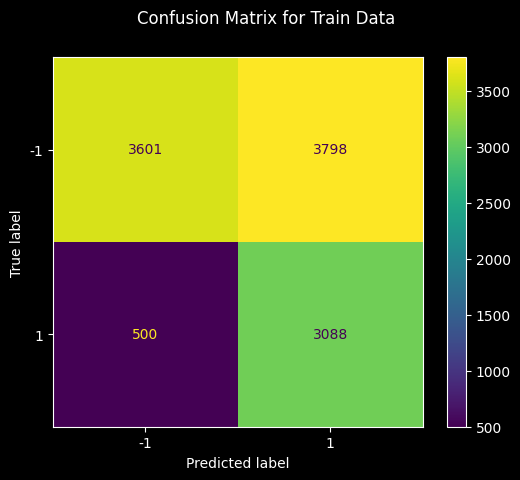

In [122]:
# Train Statistics
predictions = []

model.eval()
for i, (sentence1, sentence2, y) in tqdm(train_df[['sentence1', 'sentence2', 'y']].iterrows(), total=len(train_df)):
    sentence1 = prepare_sequence(sentence1.split(), vocab).to(device)
    sentence2 = prepare_sequence(sentence2.split(), vocab).to(device)
    y = torch.as_tensor(y).view(-1).to(device)
    out1, out2 = model(sentence1, sentence2)

    pred = F.cosine_similarity(out1, out2)
    predictions.append(pred.item())

predictions = np.array(predictions)
y_pred = (predictions>=0)*2-1
y_test = train_df['y'].to_numpy()

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

plt.suptitle('Confusion Matrix for Train Data')
plt.savefig('figs/Confusion Matrix for Train Data.jpg')

100%|██████████████████████████████████████████████████████████████████████████████| 1965/1965 [00:04<00:00, 469.67it/s]


              precision    recall  f1-score   support

          -1       0.75      0.39      0.52      1274
           1       0.40      0.76      0.53       691

    accuracy                           0.52      1965
   macro avg       0.58      0.58      0.52      1965
weighted avg       0.63      0.52      0.52      1965



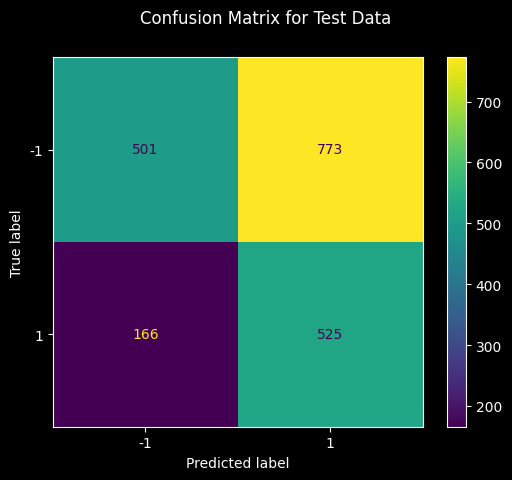

In [123]:
# Test Statistics

predictions = []

model.eval()
for i, (sentence1, sentence2, y) in tqdm(test_df[['sentence1', 'sentence2', 'y']].iterrows(), total=len(test_df)):
    sentence1 = prepare_sequence(sentence1.split(), vocab).to(device)
    sentence2 = prepare_sequence(sentence2.split(), vocab).to(device)
    y = torch.as_tensor(y).view(-1).to(device)
    out1, out2 = model(sentence1, sentence2)

    pred = F.cosine_similarity(out1, out2)
    predictions.append(pred.item())

predictions = np.array(predictions)
y_pred = (predictions>=0)*2-1
y_test = test_df['y'].to_numpy()

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

plt.suptitle('Confusion Matrix for Test Data')
plt.savefig('figs/Confusion Matrix for Test Data.jpg')